In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from shutil import copy2

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import matplotlib.pyplot as plt

In [36]:
origin_path = '../datasets/UTKFace_origin/'
debiased_path = '../datasets/UTKFace_debiased/'
images = os.listdir(origin_path)
count = 0
conflicted = []
for i in images:
    splited_i = i.split('_')
    if len(splited_i) < 4:
        count += 1
        print(i)
        conflicted.append(i)
        
for i in conflicted:
    images.remove(i)

39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg


In [37]:

ages = []
genders = []
races = []
for i in images:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    races.append(int(split[2]))
    

In [27]:
pd_images = pd.Series(list(images), name = 'Images')
pd_ages = pd.Series(list(ages), name = 'Ages')
pd_genders = pd.Series(list(genders), name = 'Genders')
pd_races = pd.Series(list(races), name = 'Races')

df = pd.concat([pd_images, pd_ages, pd_genders, pd_races], axis=1)
df

,Images,Ages,Genders,Races
0,100_0_0_20170112213500903.jpg.chip.jpg,100,0,0.0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,0,0.0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0.0
3,100_1_0_20170112213001988.jpg.chip.jpg,100,1,0.0
4,100_1_0_20170112213303693.jpg.chip.jpg,100,1,0.0
...,...,...,...,...
23703,9_1_4_20170103200637399.jpg.chip.jpg,9,1,4.0
23704,9_1_4_20170103200814791.jpg.chip.jpg,9,1,4.0
23705,9_1_4_20170103213057382.jpg.chip.jpg,9,1,NaN
23706,NaN,9,1,NaN


# EDAD

Graficamos los datos de las edades para ver como estan distribuidas

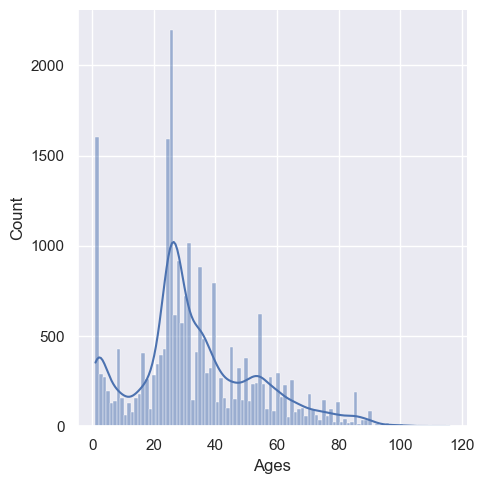

In [13]:
sns.set_theme()
sns.displot(df['Ages'],kde=True, bins=100)

In [8]:
ages_count = [0] * ages.max()
ages_count = pd.Series(list(ages_count), name = 'Ages Count')
for age in ages:
    ages_count[age-1] += 1
ages_median = ages_count.median()
print(list(ages_count))

[1123, 482, 289, 273, 196, 131, 139, 263, 166, 156, 65, 130, 81, 157, 177, 247, 158, 262, 98, 284, 346, 395, 426, 859, 734, 2197, 615, 918, 570, 724, 350, 664, 143, 409, 880, 483, 293, 325, 266, 526, 132, 266, 157, 100, 440, 153, 170, 153, 148, 381, 138, 232, 241, 353, 268, 236, 97, 271, 82, 293, 161, 125, 103, 50, 259, 77, 94, 100, 56, 147, 33, 98, 63, 32, 148, 58, 28, 69, 23, 133, 22, 40, 18, 24, 155, 35, 10, 34, 33, 82, 2, 13, 5, 0, 9, 17, 0, 0, 9, 11, 2, 0, 1, 0, 5, 0, 0, 0, 0, 5, 1, 0, 0, 0, 3, 4]


# GÉNERO

Graficamos los datos de los generos para ver las proporciones

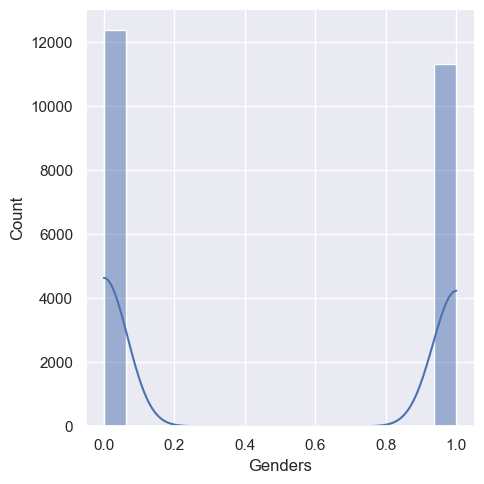

In [9]:
graph = sns.displot(df['Genders'],kde=True)

# RAZA

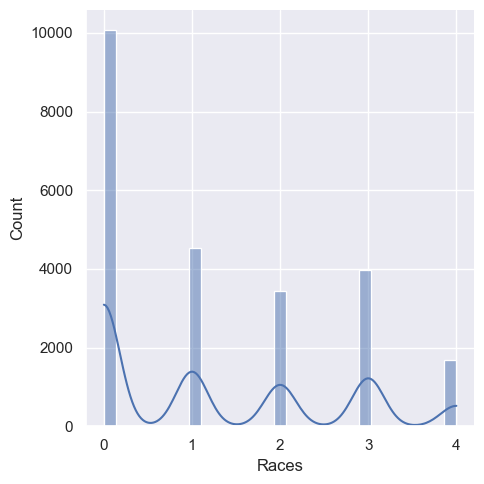

In [19]:
graph = sns.displot(df['Races'],kde=True)

In [26]:
for i in images:
    copy2(origin_path + i, debiased_path)

KeyboardInterrupt: 